In [5]:
# Required packages
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import re
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig
from trl import SFTTrainer
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate  # For metrics like BLEU

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

RuntimeError: Failed to import trl.trainer.sft_trainer because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

**Fine-Tuning Deepseek**

In [9]:
!hf auth login


^C


In [8]:
from google.colab import userdata
from huggingface_hub import login

token = userdata.get('HF_TOKEN')
login(token)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
test_model = 'deepseek-ai/deepseek-coder-1.3b-base'

tokenizer = AutoTokenizer.from_pretrained(test_model, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(
    test_model,
    torch_dtype=torch.float16,
    device_map="auto",
    use_auth_token=True,
    # offload_folder="/content/offload"
)

c:\Users\user\nganiriza_capstone\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--deepseek-ai--deepseek-coder-1.3b-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\user\nganiriza_capstone\venv\lib\site-packages\transformers\models\auto\auto_factory.p

LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `hf auth login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

: 

In [9]:
print(type(model))

<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>


In [10]:
prompt = "Explain the importance of a health mental state as a person reaches their teenage years."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        temperature=0.7,
        top_p=0.9,
        do_sample=True
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Explain the importance of a health mental state as a person reaches their teenage years.
    Answer:
    The importance of a health mental state is that it can help a person reach their teenage years.
    A person's health mental state is important because it can help a person reach their teenage years.
    The importance of a health mental state is that it can help a person reach their teenage years.
    The importance of a health mental state is that it can help a person reach their teenage years.
    The importance of a health mental state is that it can help a person reach their teenage years.
    The importance of a health mental state is that it can help a person reach their teenage years.
    The importance of a health mental state is that it


In [23]:
prompt = "Explain the importance of a health mental state as a person reaches their teenage years in kinyarwanda."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        temperature=0.7,
        top_p=0.9,
        do_sample=True
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Explain the importance of a health mental state as a person reaches their teenage years in kinyarwanda.




In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Kinyarwanda  51 non-null     object
 1   English      51 non-null     object
dtypes: object(2)
memory usage: 948.0+ bytes


In [ ]:
!pip install transformers datasets peft trl accelerate evaluate sacrebleu

In [ ]:

# Load and prepare the dataset
def format_example(row):
    return {
        "text": f"Translate from Kinyarwanda to English: {row['Kinyarwanda']}\nTranslation: {row['English']}<|endoftext|>"
    }

formatted_data = df.apply(format_example, axis=1).tolist()

# Split into train (80%) and test (20%)
train_data, test_data = train_test_split(formatted_data, test_size=0.2, random_state=42)
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

#Apply LoRA for efficient fine-tuning
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

model = get_peft_model(model, lora_config)

# Set up training arguments (tuned for small dataset and Colab GPU)
training_args = TrainingArguments(
    output_dir="./deepseek_finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    weight_decay=0.01,
    optim="adamw_torch",  # Standard optimizer (no 8-bit)
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    logging_steps=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
)

# Initialize and run the trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_args,
    packing=True,  # Retain context efficiently
)

trainer.train()



/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

## Visualizations

In [11]:
from google.colab import files
uploaded = files.upload()

Saving kinyarwanda_ds.csv to kinyarwanda_ds.csv


In [13]:
import pandas as pd

df = pd.read_csv('kinyarwanda_ds.csv')


In [14]:
df.describe()

,Kinyarwanda,English
count,51,51
unique,51,51
top,Urakoze cyane.,"""Thank you very much."""
freq,1,1


In [15]:
df.shape

(51, 2)

In [16]:
# Check for null values
df.isnull().sum()

,0
Kinyarwanda,0
English,0


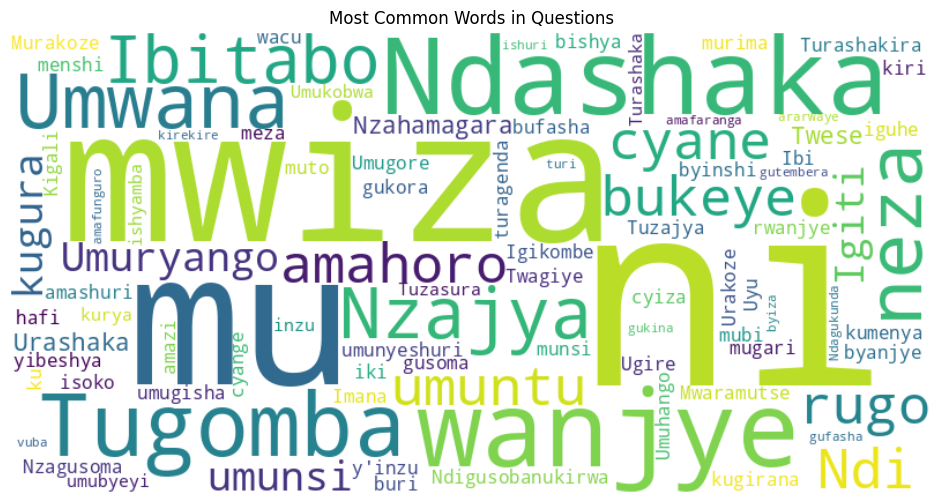

In [21]:
# Words used the most
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all questions into one string
all_questions = " ".join(q for q in df['Kinyarwanda'])


# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_questions)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Questions")
plt.show()

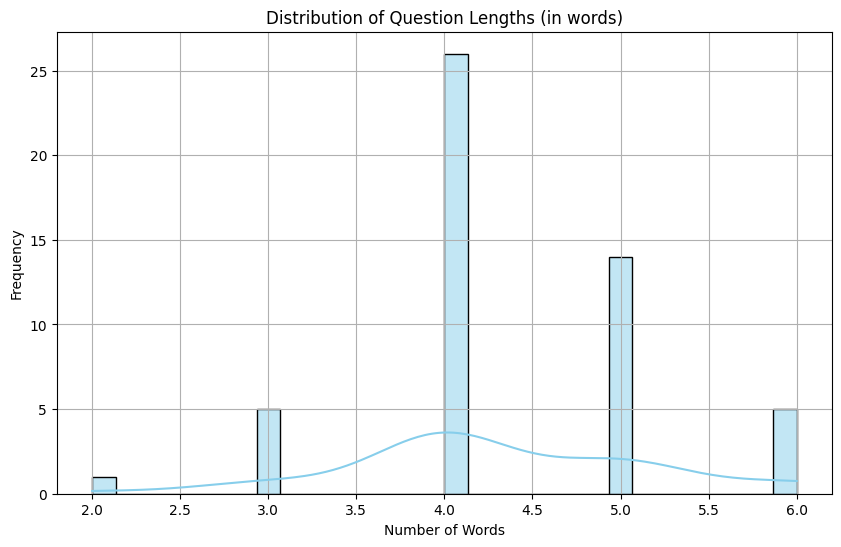

In [22]:
# Lengths of words
import seaborn as sns

# Calculate number of words per translated word
df['question_length'] = df['English'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['question_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Question Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Import necessary libraries
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import load_checkpoint_and_dispatch
import uvicorn
from pyngrok import ngrok

# Define the input data model
class PromptRequest(BaseModel):
    prompt: str

# Initialize FastAPI app
app = FastAPI(title="DeepSeek Kinyarwanda Translator API")

# Load the model and tokenizer (adjust path if fine-tuned)
model_name = "deepseek-ai/deepseek-coder-1.3b-base"  # Use "./deepseek_finetuned" if fine-tuned
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    offload_folder="/content/offload"
)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# API endpoint for generating translations
@app.post("/generate")
async def generate_translation(request: PromptRequest):
    try:
        # Prepare input
        inputs = tokenizer(f"Translate from Kinyarwanda to English: {request.prompt}\nTranslation:",
                          return_tensors="pt").to(device)

        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                temperature=0.7,
                top_p=0.9,
                do_sample=True
            )

        # Decode and clean the response
        response = tokenizer.decode(outputs[0], skip_special_tokens=True).split("\nTranslation:")[-1].strip()
        return {"response": response}

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error generating response: {str(e)}")

# Start the server with ngrok
if __name__ == "__main__":
    # Create a tunnel to the FastAPI app
    public_url = ngrok.connect(8000)
    print(f"Public URL: {public_url}")

    # Run the FastAPI app
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [ ]:
# Text cleaning
import re

def clean_text(text):
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

qa_df["input_text"] = qa_df["input_text"].apply(clean_text)
qa_df["target_text"] = qa_df["target_text"].apply(clean_text)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
train_df, val_df = train_test_split(qa_df[['input_text', 'target_text']], test_size=0.2, random_state=42)